Importação das bibliotecas e da base de dados

In [1]:
from platform import python_version
print('Versão do Python: ', python_version())

Versão do Python:  3.7.15


In [2]:
!pip install -q imdb-sqlite

In [3]:
!pip install -q pycountry

     |████████████████████████████████| 10.1 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [4]:
import re
import time
import sqlite3
import pycountry
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style = 'whitegrid')

In [5]:
%%time
!imdb-sqlite

2022-10-28 13:23:17,124 GET https://datasets.imdbws.com/name.basics.tsv.gz -> downloads/name.basics.tsv.gz
2022-10-28 13:23:19,841 GET https://datasets.imdbws.com/title.basics.tsv.gz -> downloads/title.basics.tsv.gz
2022-10-28 13:23:22,405 GET https://datasets.imdbws.com/title.akas.tsv.gz -> downloads/title.akas.tsv.gz
2022-10-28 13:23:26,257 GET https://datasets.imdbws.com/title.principals.tsv.gz -> downloads/title.principals.tsv.gz
2022-10-28 13:23:30,976 GET https://datasets.imdbws.com/title.episode.tsv.gz -> downloads/title.episode.tsv.gz
2022-10-28 13:23:32,349 GET https://datasets.imdbws.com/title.ratings.tsv.gz -> downloads/title.ratings.tsv.gz
2022-10-28 13:23:32,602 Populating database: imdb.db
2022-10-28 13:23:32,608 Applying schema
2022-10-28 13:23:32,610 Importing file: downloads/name.basics.tsv.gz
2022-10-28 13:23:32,615 Reading number of rows ...
2022-10-28 13:23:42,982 Inserting rows into table: people
100% 12035112/12035112 [02:12<00:00, 90834.34 rows/s]
2022-10-28 13:2

In [6]:
conn = sqlite3.connect('imdb.db')

In [7]:
tabelas = pd.read_sql_query("select name as 'table_name' from sqlite_master where type = 'table'", conn)

In [8]:
type(tabelas)

pandas.core.frame.DataFrame

In [9]:
tabelas.head()

,table_name
0,people
1,titles
2,akas
3,crew
4,episodes


In [10]:
tabelas = tabelas['table_name'].values.tolist()

In [11]:
for tabela in tabelas:
  consulta = 'pragma table_info({})'.format(tabela)
  resultado = pd.read_sql_query(consulta, conn)
  print('Esquema da tabela: ', tabela)
  display(resultado)
  print('-' * 100)
  print('\n')

Esquema da tabela:  people


,cid,name,type,notnull,dflt_value,pk
0,0,person_id,VARCHAR,0,None,1
1,1,name,VARCHAR,0,None,0
2,2,born,INTEGER,0,None,0
3,3,died,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  titles


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,type,VARCHAR,0,None,0
2,2,primary_title,VARCHAR,0,None,0
3,3,original_title,VARCHAR,0,None,0
4,4,is_adult,INTEGER,0,None,0
5,5,premiered,INTEGER,0,None,0
6,6,ended,INTEGER,0,None,0
7,7,runtime_minutes,INTEGER,0,None,0
8,8,genres,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  akas


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,title,VARCHAR,0,None,0
2,2,region,VARCHAR,0,None,0
3,3,language,VARCHAR,0,None,0
4,4,types,VARCHAR,0,None,0
5,5,attributes,VARCHAR,0,None,0
6,6,is_original_title,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  crew


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,0
1,1,person_id,VARCHAR,0,None,0
2,2,category,VARCHAR,0,None,0
3,3,job,VARCHAR,0,None,0
4,4,characters,VARCHAR,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  episodes


,cid,name,type,notnull,dflt_value,pk
0,0,episode_title_id,INTEGER,0,None,0
1,1,show_title_id,INTEGER,0,None,0
2,2,season_number,INTEGER,0,None,0
3,3,eposide_number,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------


Esquema da tabela:  ratings


,cid,name,type,notnull,dflt_value,pk
0,0,title_id,VARCHAR,0,None,1
1,1,rating,INTEGER,0,None,0
2,2,votes,INTEGER,0,None,0


----------------------------------------------------------------------------------------------------




1ª consulta - Categorias mais comuns

In [12]:
consulta1 = '''select type, count(*) as count from titles group by type'''

In [13]:
resultado1 = pd.read_sql_query(consulta1, conn)

In [14]:
display(resultado1)

,type,count
0,movie,625552
1,short,896966
2,tvEpisode,7041233
3,tvMiniSeries,45734
4,tvMovie,138032
5,tvPilot,2
6,tvSeries,233252
7,tvShort,10703
8,tvSpecial,38858
9,video,266554


In [15]:
resultado1['percentual'] = (resultado1['count'] / resultado1['count'].sum()) * 100

In [16]:
display(resultado1)

,type,count,percentual
0,movie,625552,6.705077
1,short,896966,9.614271
2,tvEpisode,7041233,75.472561
3,tvMiniSeries,45734,0.490207
4,tvMovie,138032,1.479518
5,tvPilot,2,0.000021
6,tvSeries,233252,2.500148
7,tvShort,10703,0.114722
8,tvSpecial,38858,0.416506
9,video,266554,2.857101


In [17]:
others = {}

others['count'] = resultado1[resultado1['percentual'] < 5]['count'].sum()

others['percentual'] = resultado1[resultado1['percentual'] < 5]['percentual'].sum()

others['type'] = 'others'

In [18]:
others

{'count': 765776, 'percentual': 8.208090292251686, 'type': 'others'}

In [19]:
resultado1 = resultado1[resultado1['percentual'] > 5]

In [20]:
resultado1 = resultado1.append(others, ignore_index = True)

In [21]:
resultado1 = resultado1.sort_values(by = 'count', ascending = False)

In [22]:
resultado1.head()

,type,count,percentual
2,tvEpisode,7041233,75.472561
1,short,896966,9.614271
3,others,765776,8.208090
0,movie,625552,6.705077


In [23]:
labels = [str(resultado1['type'][i])+' '+'['+str(round(resultado1['percentual'][i], 2)) + '%' +']' for i in resultado1.index]

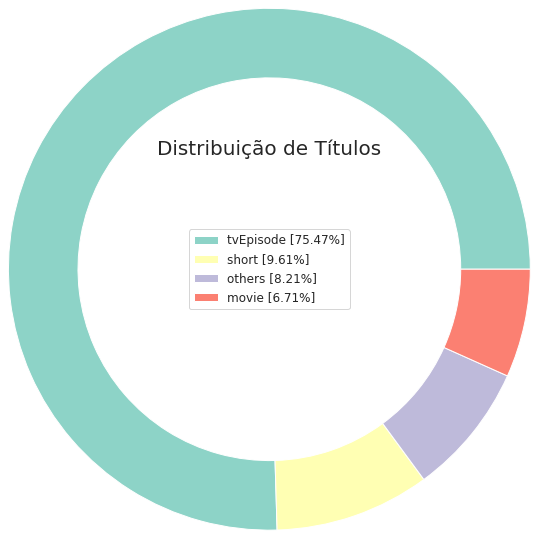

In [24]:
cs = cm.Set3(np.arange(100))

f = plt.figure()

plt.pie(resultado1['count'], labeldistance = 1, radius = 3, colors = cs, wedgeprops = dict(width = 0.8))
plt.legend(labels = labels, loc = 'center', prop = {'size': 12})
plt.title('Distribuição de Títulos', loc = 'Center', fontdict = {'fontsize': 20, 'fontweight': 20})
plt.show()

2ª consulta - Títulos por gênero

In [25]:
consulta2 = '''select genres, count(*) from titles where type = 'movie' group by genres'''

In [26]:
resultado2 = pd.read_sql_query(consulta2, conn)

In [27]:
display(resultado2)

,genres,count(*)
0,Action,14244
1,"Action,Adult",11
2,"Action,Adult,Adventure",2
3,"Action,Adult,Comedy",6
4,"Action,Adult,Crime",9
...,...,...
1464,"Thriller,Western",42
1465,War,1316
1466,"War,Western",15
1467,Western,5169


In [28]:
resultado2['genres'] = resultado2['genres'].str.lower().values

In [29]:
temp = resultado2['genres'].dropna()

In [30]:
padrao = '(?u)\\b[\\w-]+\\b'

vetor = CountVectorizer(token_pattern = padrao, analyzer = 'word').fit(temp)

In [31]:
type(vetor)

sklearn.feature_extraction.text.CountVectorizer

In [32]:
bag_generos = vetor.transform(temp)

In [33]:
type(bag_generos)

scipy.sparse.csr.csr_matrix

In [34]:
generos_unicos = vetor.get_feature_names()

In [35]:
generos = pd.DataFrame(bag_generos.todense(), columns = generos_unicos, index = temp.index)

In [36]:
generos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469 entries, 0 to 1468
Data columns (total 29 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   action       1469 non-null   int64
 1   adult        1469 non-null   int64
 2   adventure    1469 non-null   int64
 3   animation    1469 non-null   int64
 4   biography    1469 non-null   int64
 5   comedy       1469 non-null   int64
 6   crime        1469 non-null   int64
 7   documentary  1469 non-null   int64
 8   drama        1469 non-null   int64
 9   family       1469 non-null   int64
 10  fantasy      1469 non-null   int64
 11  film-noir    1469 non-null   int64
 12  game-show    1469 non-null   int64
 13  history      1469 non-null   int64
 14  horror       1469 non-null   int64
 15  music        1469 non-null   int64
 16  musical      1469 non-null   int64
 17  mystery      1469 non-null   int64
 18  n            1469 non-null   int64
 19  news         1469 non-null   int64
 20  reality-

In [37]:
generos = generos.drop(columns = 'n', axis = 0)

In [38]:
generos_percentual = 100 * pd.Series(generos.sum()).sort_values(ascending = False) / generos.shape[0]

In [39]:
generos_percentual.head(10)

drama          17.971409
comedy         17.086453
documentary    15.997277
adventure      14.703880
action         14.499660
romance        13.274336
crime          13.002042
mystery        12.389381
thriller       12.253233
horror         12.185160
dtype: float64

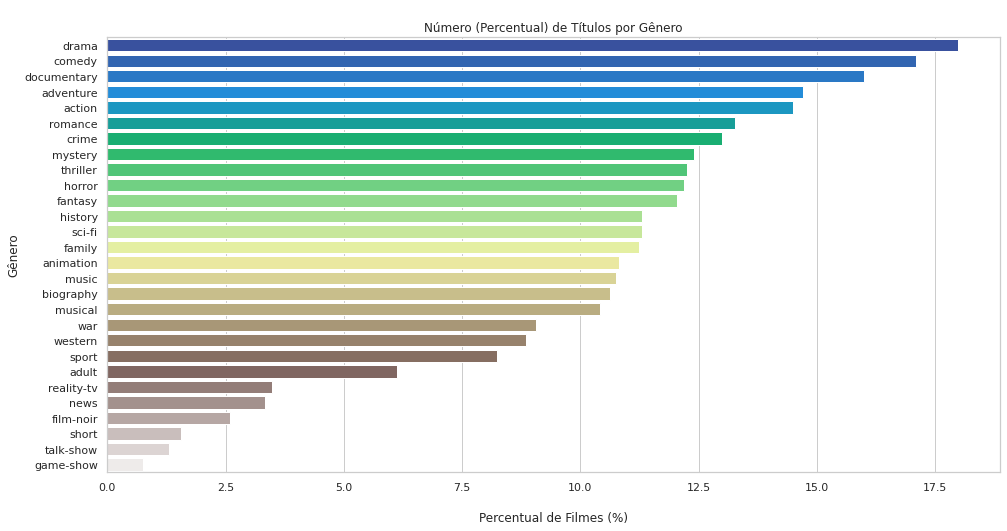

In [40]:
plt.figure(figsize = (16, 8))
sns.barplot(x = generos_percentual.values, y = generos_percentual.index, orient = 'h', palette = 'terrain')
plt.ylabel('Gênero')
plt.xlabel('\nPercentual de Filmes (%)')
plt.title('\nNúmero (Percentual) de Títulos por Gênero')
plt.show()

3ª consulta - Mediana de avaliação dos filmes por gênero

In [41]:
consulta3 = '''
            select rating, genres
            from ratings
            join titles on ratings.title_id = titles.title_id
            where premiered <= 2022 and type = 'movie'
            '''

In [42]:
resultado3 = pd.read_sql_query(consulta3, conn)

In [43]:
display(resultado3)

,rating,genres
0,5.2,Romance
1,4.2,\N
2,6.0,"Action,Adventure,Biography"
3,5.1,Drama
4,4.3,Drama
...,...,...
282010,5.8,Thriller
282011,6.4,"Drama,History"
282012,3.8,"Adventure,History,War"
282013,8.3,Drama


In [44]:
def retorna_generos(df):
  df['genres'] = df['genres'].str.lower().values
  temp = df['genres'].dropna()
  vetor = CountVectorizer(token_pattern = '(?u)\\b[\\w-]+\\b', analyzer = 'word').fit(temp)
  generos_unicos = vetor.get_feature_names()
  generos_unicos = [genre for genre in generos_unicos if len(genre) > 1]
  return generos_unicos

In [45]:
generos_unicos = retorna_generos(resultado3)

In [46]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [47]:
genero_counts = []
genero_ratings = []

In [48]:
for item in generos_unicos:
  consulta = 'select count(rating) from ratings join titles on ratings.title_id = titles.title_id where genres like '+ '\'' + '%' + item + '%' + '\' and type = \'movie\''
  resultado = pd.read_sql_query(consulta, conn)
  genero_counts.append(resultado.values[0][0])

  consulta = 'select rating from ratings join titles on ratings.title_id = titles.title_id where genres like '+ '\'' + '%' + item + '%' + '\' and type = \'movie\''
  resultado = pd.read_sql_query(consulta, conn)
  genero_ratings.append(np.median(resultado['rating']))

In [49]:
df_genero_ratings = pd.DataFrame()
df_genero_ratings['genres'] = generos_unicos
df_genero_ratings['count'] = genero_counts
df_genero_ratings['rating'] = genero_ratings

In [50]:
df_genero_ratings.head(20)

,genres,count,rating
0,action,29281,5.8
1,adult,4106,5.7
2,adventure,17735,6.0
3,animation,4866,6.6
4,biography,8670,7.0
5,comedy,69752,6.0
6,crime,24257,6.1
7,documentary,42689,7.3
8,drama,125311,6.4
9,family,10905,6.3


In [51]:
df_genero_ratings = df_genero_ratings.drop(index = 18)

In [52]:
df_genero_ratings = df_genero_ratings.sort_values(by = 'rating', ascending = False)

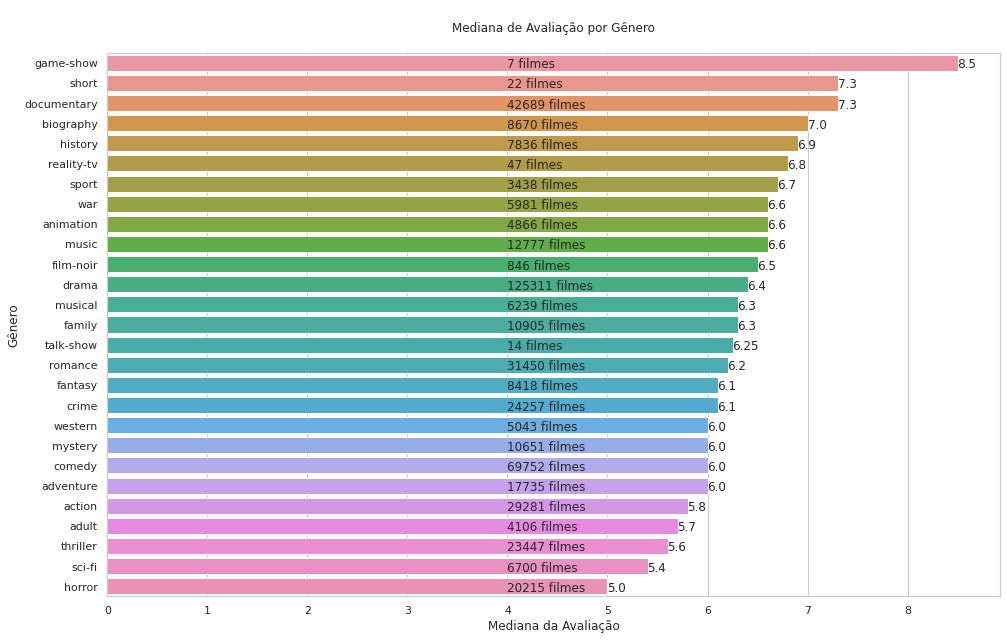

In [53]:
plt.figure(figsize = (16, 10))

sns.barplot(y = df_genero_ratings.genres, x = df_genero_ratings.rating, orient = 'h')

for i in range(len(df_genero_ratings.index)):
  plt.text(4.0,
           i + 0.25,
           str(df_genero_ratings['count'][df_genero_ratings.index[i]]) + ' filmes')
  
  plt.text(df_genero_ratings.rating[df_genero_ratings.index[i]],
           i + 0.25,
           round(df_genero_ratings['rating'][df_genero_ratings.index[i]], 2))

plt.ylabel('Gênero')
plt.xlabel('Mediana da Avaliação')
plt.title('\nMediana de Avaliação por Gênero\n')
plt.show()

4ª consulta - Mediana de avaliação de filmes em relação ao ano de estreia

In [54]:
consulta4 = '''
            select rating as Rating, premiered
            from ratings
            join titles on ratings.title_id = titles.title_id
            where premiered <= 2022 and type = 'movie'
            order by premiered
            '''

In [55]:
resultado4 = pd.read_sql_query(consulta4, conn)

In [56]:
display(resultado4)

,Rating,premiered
0,5.2,1894
1,4.5,1897
2,3.9,1899
3,3.4,1899
4,5.9,1900
...,...,...
282010,8.0,2022
282011,6.8,2022
282012,5.3,2022
282013,3.9,2022


In [57]:
ratings = []

for year in set(resultado4['premiered']):
  ratings.append(np.median(resultado4[resultado4['premiered'] == year]['Rating']))

In [58]:
type(ratings)

list

In [59]:
ratings[1:10]

[4.5, 3.65, 5.85, 4.3, 3.3, 5.25, 5.3, 4.1, 3.1]

In [60]:
anos = list(set(resultado4['premiered']))

In [61]:
anos[1:10]

[1897, 1899, 1900, 1901, 1902, 1903, 1904, 1905, 1906]

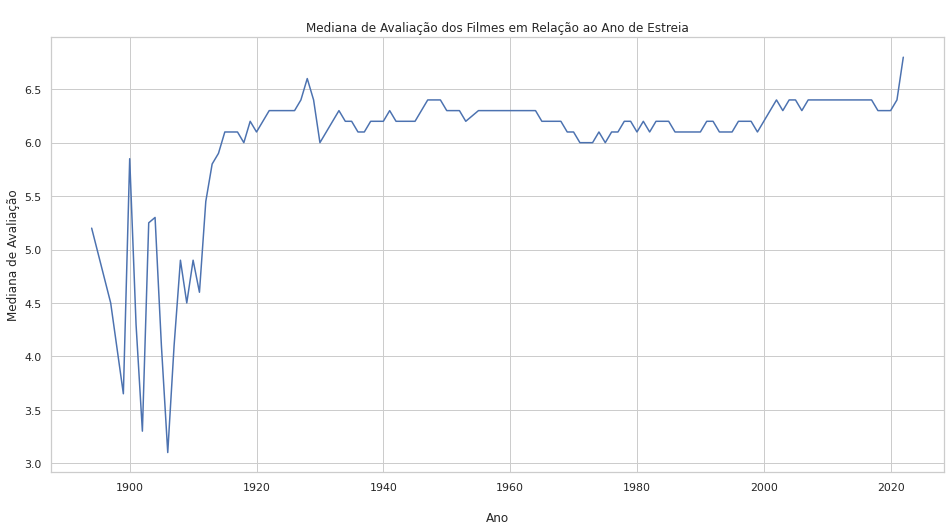

In [62]:
plt.figure(figsize = (16, 8))
plt.plot(anos, ratings)
plt.xlabel('\nAno')
plt.ylabel('Mediana de Avaliação')
plt.title('\nMediana de Avaliação dos Filmes em Relação ao Ano de Estreia')
plt.show()

5ª consulta - Quantidade de filmes avaliados por gênero em relação ao ano de estreia

In [63]:
consulta5 = '''select genres from titles'''

In [64]:
resultado5 = pd.read_sql_query(consulta5, conn)

In [65]:
display(resultado5)

,genres
0,"Documentary,Short"
1,"Animation,Short"
2,"Animation,Comedy,Romance"
3,"Animation,Short"
4,"Comedy,Short"
...,...
9329522,"Action,Drama,Family"
9329523,"Action,Drama,Family"
9329524,"Action,Drama,Family"
9329525,Short


In [66]:
generos_unicos = retorna_generos(resultado5)

In [67]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [68]:
genero_count = []

for item in generos_unicos:
  consulta = 'select count(*) count from titles where genres like '+ '\'' + '%' + item + '%' + '\' and type = \'movie\' and premiered <= 2022'
  resultado = pd.read_sql_query(consulta, conn)
  genero_count.append(resultado['count'].values[0])

In [69]:
df_genero_count = pd.DataFrame()
df_genero_count['genre'] = generos_unicos
df_genero_count['Count'] = genero_count

In [70]:
df_genero_count = df_genero_count[df_genero_count['genre'] != 'n']
df_genero_count = df_genero_count.sort_values(by = 'Count', ascending = False)
top_generos = df_genero_count.head()['genre'].values

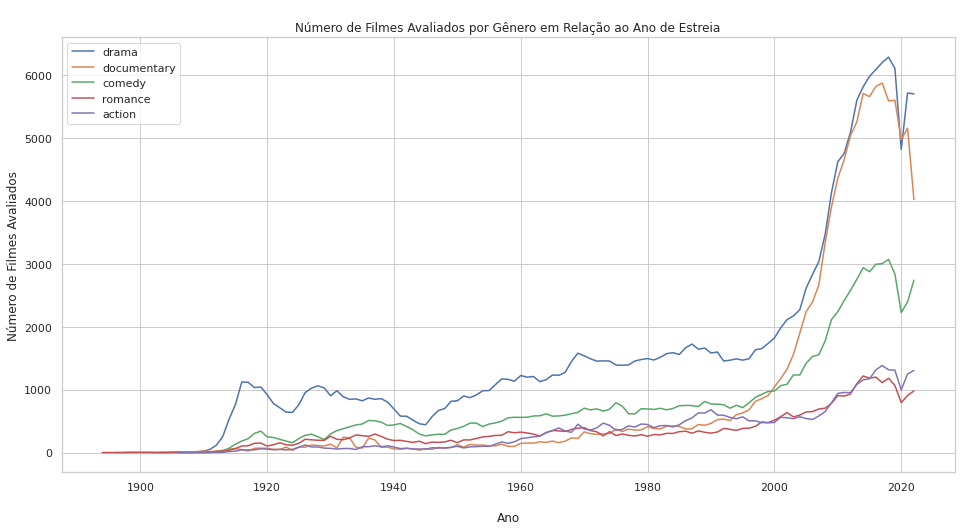

In [71]:
plt.figure(figsize = (16, 8))

for item in top_generos:
  consulta = 'select count(*) Number_of_movies, premiered Year from titles where genres like '+ '\'' + '%' + item + '%' + '\' and type = \'movie\' and Year <= 2022 group by Year'
  resultado = pd.read_sql_query(consulta, conn)
  plt.plot(resultado['Year'], resultado['Number_of_movies'])

plt.xlabel('\nAno')
plt.ylabel('Número de Filmes Avaliados')
plt.title('\nNúmero de Filmes Avaliados por Gênero em Relação ao Ano de Estreia')
plt.legend(labels = top_generos)
plt.show()

6ª consulta - Filme de maior duração e cálculo de percentis

In [72]:
consulta6 = '''
            select runtime_minutes Runtime
            from titles
            where type = 'movie' and Runtime != 'NaN'
            '''

In [73]:
resultado6 = pd.read_sql_query(consulta6, conn)

In [74]:
display(resultado6)

,Runtime
0,45
1,100
2,70
3,90
4,120
...,...
394925,123
394926,57
394927,100
394928,116


In [75]:
for i in range(101):
  val = i
  perc = round(np.percentile(resultado6['Runtime'].values, val), 2)
  print('{} percentil da duração (runtime) é: {}'.format(val, perc))

0 percentil da duração (runtime) é: 1.0
1 percentil da duração (runtime) é: 45.0
2 percentil da duração (runtime) é: 47.0
3 percentil da duração (runtime) é: 50.0
4 percentil da duração (runtime) é: 50.0
5 percentil da duração (runtime) é: 51.0
6 percentil da duração (runtime) é: 52.0
7 percentil da duração (runtime) é: 53.0
8 percentil da duração (runtime) é: 54.0
9 percentil da duração (runtime) é: 56.0
10 percentil da duração (runtime) é: 57.0
11 percentil da duração (runtime) é: 58.0
12 percentil da duração (runtime) é: 60.0
13 percentil da duração (runtime) é: 60.0
14 percentil da duração (runtime) é: 60.0
15 percentil da duração (runtime) é: 61.0
16 percentil da duração (runtime) é: 62.0
17 percentil da duração (runtime) é: 64.0
18 percentil da duração (runtime) é: 65.0
19 percentil da duração (runtime) é: 67.0
20 percentil da duração (runtime) é: 69.0
21 percentil da duração (runtime) é: 70.0
22 percentil da duração (runtime) é: 70.0
23 percentil da duração (runtime) é: 71.0
24 

In [79]:
consulta6_1 = '''
              select runtime_minutes Runtime, primary_title
              from titles
              where type = 'movie' and Runtime != 'NaN'
              order by Runtime desc
              limit 1
              '''

In [80]:
resultado6_1 = pd.read_sql_query(consulta6_1, conn)

In [81]:
resultado6_1

,Runtime,primary_title
0,51420,Logistics


7ª consulta - Relação entre duração e gênero

In [82]:
consulta7 = '''
            select avg(runtime_minutes) Runtime, genres
            from titles
            where type = 'movie' and runtime_minutes != 'NaN'
            group by genres
            '''

In [83]:
resultado7 = pd.read_sql_query(consulta7, conn)

In [84]:
generos_unicos = retorna_generos(resultado7)

In [85]:
generos_unicos

['action',
 'adult',
 'adventure',
 'animation',
 'biography',
 'comedy',
 'crime',
 'documentary',
 'drama',
 'family',
 'fantasy',
 'film-noir',
 'game-show',
 'history',
 'horror',
 'music',
 'musical',
 'mystery',
 'news',
 'reality-tv',
 'romance',
 'sci-fi',
 'short',
 'sport',
 'talk-show',
 'thriller',
 'war',
 'western']

In [86]:
genero_runtime = []

for item in generos_unicos:
  consulta = 'select runtime_minutes Runtime from titles where genres like '+ '\'' + '%' + item + '%' + '\' and type = \'movie\' and Runtime != \'NaN\''
  resultado = pd.read_sql_query(consulta, conn)
  genero_runtime.append(np.median(resultado['Runtime']))

In [87]:
df_genero_runtime = pd.DataFrame()
df_genero_runtime['genre'] = generos_unicos
df_genero_runtime['runtime'] = genero_runtime

In [88]:
df_genero_runtime = df_genero_runtime.drop(index = 18)

In [89]:
dt_genero_runtime = df_genero_runtime.sort_values(by = 'runtime', ascending = False)

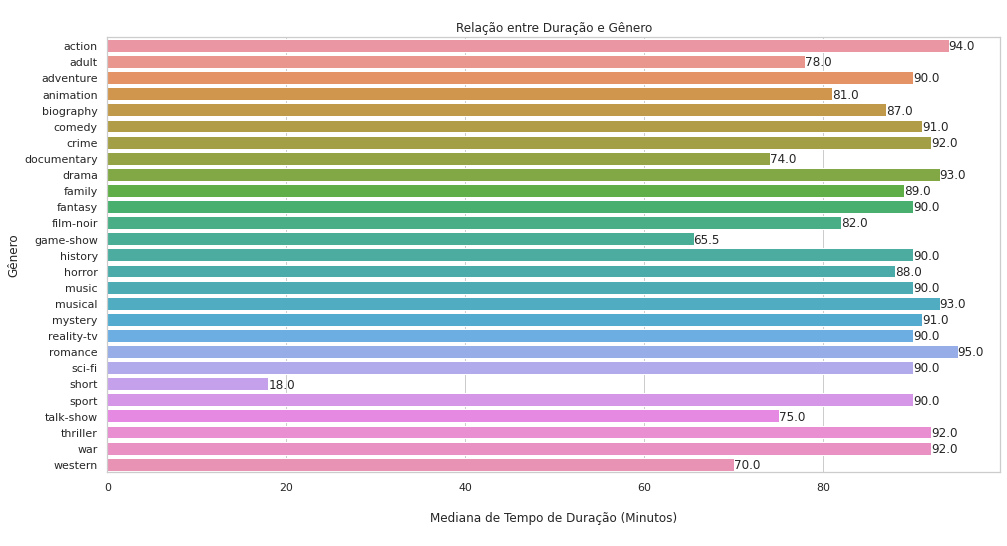

In [91]:
plt.figure(figsize = (16, 8))

sns.barplot(y = df_genero_runtime.genre, x = dt_genero_runtime.runtime, orient = 'h')

for i in range(len(df_genero_runtime.index)):
  plt.text(df_genero_runtime.runtime[df_genero_runtime.index[i]],
           i + 0.25,
           round(df_genero_runtime['runtime'][df_genero_runtime.index[i]], 2))

plt.ylabel('Gênero')
plt.xlabel('\nMediana de Tempo de Duração (Minutos)\n')
plt.title('\nRelação entre Duração e Gênero')
plt.show()

8ª consulta - Número de filmes produzidos por país

In [92]:
consulta8 = '''
            select region, count(*) Number_of_movies
            from akas
            join titles on akas.title_id = titles.title_id
            where region != 'None' and type = \'movie\'
            group by region
            '''

In [93]:
resultado8 = pd.read_sql_query(consulta8, conn)

In [94]:
display(resultado8)

,region,Number_of_movies
0,AD,22
1,AE,8613
2,AF,111
3,AG,12
4,AL,1306
...,...,...
230,YUCS,152
231,ZA,10264
232,ZM,47
233,ZRCD,2


In [95]:
resultado8.shape

(235, 2)

In [96]:
resultado8.shape[0]

235

In [98]:
nomes_paises = []
contagem = []

In [99]:
for i in range(resultado8.shape[0]):
  try:
    coun = resultado8['region'].values[i]
    nomes_paises.append(pycountry.countries.get(alpha_2 = coun).name)
    contagem.append(resultado8['Number_of_movies'].values[i])
  except:
    continue


In [100]:
df_filmes_paises = pd.DataFrame()
df_filmes_paises['country'] = nomes_paises
df_filmes_paises['Movie_Count'] = contagem

In [101]:
df_filmes_paises = df_filmes_paises.sort_values(by = 'Movie_Count', ascending = False)

In [102]:
df_filmes_paises.head(10)

,country,Movie_Count
200,United States,319109
66,United Kingdom,162307
97,Japan,94495
90,India,89095
64,France,86886
32,Canada,82948
48,Germany,74154
59,Spain,67945
94,Italy,67584
26,Brazil,66871


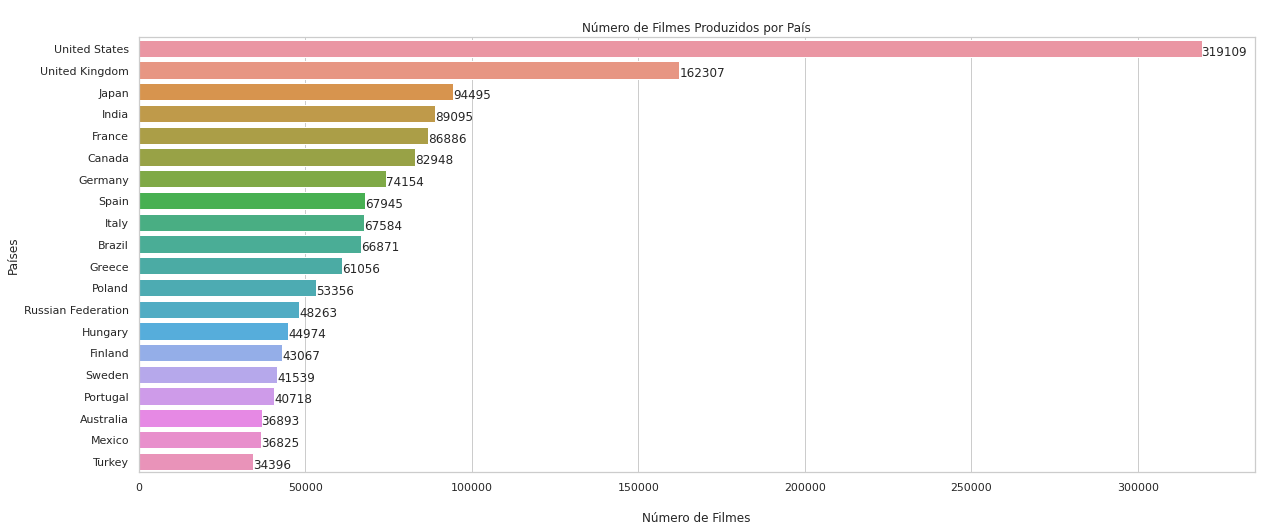

In [105]:
plt.figure(figsize = (20, 8))

sns.barplot(y = df_filmes_paises[:20].country, x = df_filmes_paises[:20].Movie_Count, orient = 'h')

for i in range(0, 20):
  plt.text(df_filmes_paises.Movie_Count[df_filmes_paises.index[i]] - 1,
           i + 0.30,
           round(df_filmes_paises['Movie_Count'][df_filmes_paises.index[i]], 2))
  
plt.ylabel('Países')
plt.xlabel('\nNúmero de Filmes')
plt.title('\nNúmero de Filmes Produzidos por País')
plt.show()

9ª consulta - Top 10 melhores filmes

In [108]:
consulta9 = '''
            select primary_title as Movie_Name, genres, rating
            from titles
            join ratings on titles.title_id = ratings.title_id
            where titles.type = 'movie' and ratings.votes >= 25000
            order by rating desc
            limit 10
            '''

In [109]:
top10_melhores_filmes = pd.read_sql_query(consulta9, conn)

In [110]:
display(top10_melhores_filmes)

,Movie_Name,genres,rating
0,The Shawshank Redemption,Drama,9.3
1,The Godfather,"Crime,Drama",9.2
2,The Chaos Class,"Comedy,Drama",9.2
3,Kantara,"Action,Adventure,Drama",9.2
4,CM101MMXI Fundamentals,"Comedy,Documentary",9.1
5,12 Angry Men,"Crime,Drama",9.0
6,The Godfather Part II,"Crime,Drama",9.0
7,Schindler's List,"Biography,Drama,History",9.0
8,The Lord of the Rings: The Return of the King,"Action,Adventure,Drama",9.0
9,The Dark Knight,"Action,Crime,Drama",9.0


10ª consulta - Top 10 piores filmes

In [111]:
consulta10 = '''
            select primary_title as Movie_Name, genres, rating
            from titles
            join ratings on titles.title_id = ratings.title_id
            where titles.type = 'movie' and ratings.votes >= 25000
            order by rating asc
            limit 10
            '''

In [112]:
top10_piores_filmes = pd.read_sql_query(consulta10, conn)

In [113]:
display(top10_piores_filmes)

,Movie_Name,genres,rating
0,Reis,"Biography,Drama",1.0
1,Cumali Ceber,Comedy,1.0
2,Sadak 2,"Action,Drama",1.1
3,Smolensk,"Drama,Thriller",1.2
4,Superbabies: Baby Geniuses 2,"Comedy,Family,Sci-Fi",1.5
5,The Cost of Deception,"Action,Crime,Drama",1.5
6,Manos: The Hands of Fate,Horror,1.6
7,Justin Bieber: Never Say Never,"Documentary,Music",1.6
8,From Justin to Kelly,"Comedy,Musical,Romance",1.9
9,The Hottie & the Nottie,"Comedy,Romance",1.9
